In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Some Reference
https://www.kaggle.com/eikedehling/tune-and-compare-xgb-lightgbm-rf-with-hyperopt
http://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html

# Dataset loading

In [2]:
dataset = pd.read_csv('../Y3 - Sample data/Z2 - datasetprepclean.csv', index_col = 0,
                     )
print('dataset shape:', dataset.shape)
dataset.head()

dataset shape: (5401, 665)


,cut_length,num_closed_patterns,num_open_patterns,total_area,minimum_rectangle_area,minimum_rectangle_dim1,minimum_rectangle_dim2,convex_hull_area,no_hole_area,thickness,...,bendlength_bend_edge_length_min_04,bendlength_bend_edge_length_max_04,weight,VAMAT,VALAJOUT,VALTOT,VOL_COST_CONVHULL,VOL_COST_RECTANGLE,VOL_COST_MPATTERN,bend_group
COART,,,,,,,,,,,,,,,,,,,,,
L1600360,3178.489502,9,0,285678.093750,431798.46875,722.070984,598.000000,320484.593750,286893.718750,4.0,...,29.010676,594.972659,13.273485,12.51,5.15,17.66,0.000010,0.000007,0.000011,3-5
L1600470,317.114502,1,0,3403.138184,3500.00000,140.000000,25.000000,3403.138184,3403.138184,10.0,...,0.000000,0.000000,0.268975,0.25,0.92,1.17,0.000007,0.000007,0.000007,0
L1600600,3710.627930,1,0,522587.812500,522587.81250,1509.000000,346.313995,522587.812500,522587.812500,3.0,...,0.000000,0.000000,12.048263,18.36,7.55,25.91,0.000012,0.000012,0.000012,1-2
L1600610,3232.627930,1,0,439818.781250,439818.78125,1270.000000,346.313995,439818.781250,439818.781250,3.0,...,0.000000,0.000000,10.140022,9.18,4.77,13.95,0.000007,0.000007,0.000007,1-2
L1600620,2972.627930,1,0,394797.968750,394797.96875,1140.000000,346.313995,394797.968750,394797.968750,3.0,...,0.000000,0.000000,9.102067,9.18,4.65,13.83,0.000008,0.000008,0.000008,1-2


In [3]:
dataset.columns.values

array(['cut_length', 'num_closed_patterns', 'num_open_patterns',
       'total_area', 'minimum_rectangle_area', 'minimum_rectangle_dim1',
       'minimum_rectangle_dim2', 'convex_hull_area', 'no_hole_area',
       'thickness', 'radius_approx', 'radius_count', 'direction_count',
       'bend_count', 'benddxf_bend_radius_00', 'benddxf_bend_angle_00',
       'benddxf_bend_direction_00', 'benddxf_deformation_length_00',
       'benddxf_merged_bend_00', 'benddxf_punch_length_00',
       'benddxf_bend_radius_01', 'benddxf_bend_angle_01',
       'benddxf_bend_direction_01', 'benddxf_deformation_length_01',
       'benddxf_merged_bend_01', 'benddxf_punch_length_01',
       'benddxf_bend_radius_02', 'benddxf_bend_angle_02',
       'benddxf_bend_direction_02', 'benddxf_deformation_length_02',
       'benddxf_merged_bend_02', 'benddxf_punch_length_02',
       'benddxf_bend_radius_03', 'benddxf_bend_angle_03',
       'benddxf_bend_direction_03', 'benddxf_deformation_length_03',
       'benddxf_mer

In [4]:
for index, nancount in dataset.isnull().sum().iteritems():
    if nancount != 0:
        print(index, '-->', nancount)
else:
    print('Done !')

dataset.shape

benddxf_deformation_length_00 --> 262
benddxf_deformation_length_01 --> 123
benddxf_deformation_length_02 --> 19
benddxf_deformation_length_03 --> 6
benddxf_deformation_length_04 --> 1
benddxf_deformation_length_05 --> 1
bendlength_deformation_length_00 --> 296
bendlength_deformation_length_01 --> 112
bendlength_deformation_length_02 --> 3
bendlength_deformation_length_03 --> 1
Done !


(5401, 665)

In [5]:
#Cleaning of the remaining Nan

subset = [x for x in dataset.columns.values if x.startswith('benddxf_')]

#dataset = dataset.fillna(0)
dataset = dataset.dropna(subset=subset)
dataset.shape

(5105, 665)

# cleaning to have at least min occurences

In [6]:
minocc = 50
todrop = []
df = dataset['thickness'].reset_index().groupby('thickness').count()
for index, occ in df.iterrows():
    if occ.COART <= minocc:
        print(occ.COART)
        todrop.append(index)
        print(index, 'will be dropped')

for thickness in todrop:
    dataset = dataset[dataset['thickness'] != thickness]

dataset.shape

33
1.5 will be dropped
1
2.5 will be dropped
6
20.0 will be dropped


(5065, 665)

# Target definition

In [7]:
target = 'VALAJOUT'
completecleaning = True
assert target in ['VAMAT', 'VALAJOUT', 'VALTOT'], 'The target must be in y dataset'

# Is the target "normal" ?

In [8]:
from scipy.stats import skew
skew(dataset[target]) #Nope !

3.1520528420901357

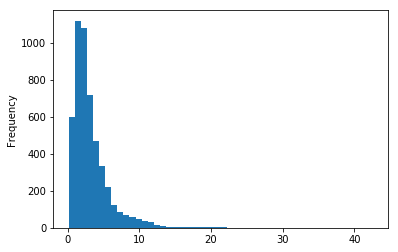

In [9]:
dataset[target].plot.hist(bins=50)
plt.show()

# Outlier tracking - VAMAT

In [10]:
toplimit = .95 #We drop the top 5%
botlimit = .02 #we drop the bottom 2%

In [11]:
#Surface cost calculation, quantile decomposition

#dataset['SURF_COST_CONVHULL'] = dataset['VAMAT'] / dataset['convex_hull_area']
dataset['SURF_COST_RECTANGLE'] = dataset['VAMAT'] / dataset['minimum_rectangle_area']
dataset['SURF_COST_MPATTERN'] = dataset['VAMAT'] / dataset['no_hole_area']
#dataset['SURF_COST_TOTAREA'] = dataset['VAMAT'] / dataset['total_area']

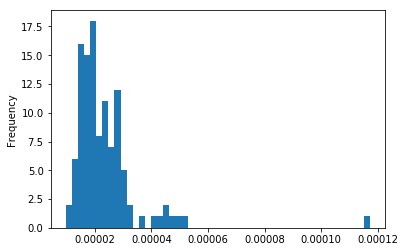

In [12]:
df = dataset[dataset['thickness'] == 2]
df['SURF_COST_MPATTERN'].plot.hist(bins=50)
plt.show()

In [13]:
#quantile decomposition
df=dataset[['thickness', 'SURF_COST_MPATTERN']].groupby('thickness').quantile([botlimit,toplimit])
df

SURF_COST_MPATTERN
thickness                         
2.0       0.02            0.000013
          0.95            0.000045
3.0       0.02            0.000018
          0.95            0.000060
4.0       0.02            0.000023
          0.95            0.000089
5.0       0.02            0.000028
          0.95            0.000091
6.0       0.02            0.000033
          0.95            0.000134
8.0       0.02            0.000044
          0.95            0.000182
10.0      0.02            0.000063
          0.95            0.000248
12.0      0.02            0.000059
          0.95            0.000247
15.0      0.02            0.000085
          0.95            0.000271

In [14]:
# If vamat is target, cleaning
if target == 'VAMAT' or target == 'VALTOT' or completecleaning:
    for (thickness, limit), value in df.iterrows():
        tresh = value.values[0]
        if limit == botlimit:
            mask = np.logical_and(dataset['thickness'] == thickness, dataset[df.columns.values[0]] < tresh)
            dataset = dataset[np.logical_not(mask)]
        elif limit == toplimit:
            mask = np.logical_and(dataset['thickness'] == thickness, dataset[df.columns.values[0]] > tresh)
            dataset = dataset[np.logical_not(mask)]
        #print((thickness, limit), tresh)

dataset.shape

(4704, 667)

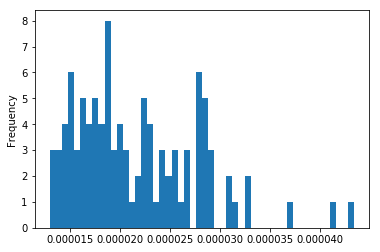

In [15]:
df = dataset[dataset['thickness'] == 2]
df['SURF_COST_MPATTERN'].plot.hist(bins=50)
plt.show()

In [16]:
skew(dataset[target])

3.3050947633493086

/Users/cricket/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


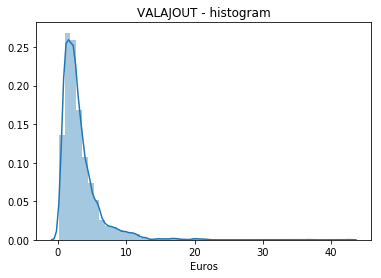

In [17]:
sns.distplot(dataset[target],)
plt.title(f'{target} - histogram')
plt.xlabel('Euros')
plt.show()

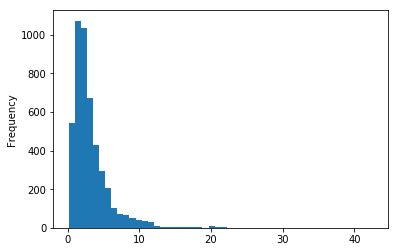

In [18]:
dataset[target].plot.hist(bins=50)
plt.show()

# Outlier tracking - VALAJOUT

In [19]:
toplimit = .95 #We drop the top 5%
botlimit = .02 #we drop the bottom 2%

In [20]:
#Cost per bend calculation

dataset['APPROX_BEND_COST'] = dataset['VALAJOUT'] / (dataset['bend_count']+1)

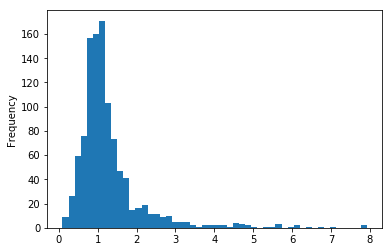

In [21]:
df = dataset[dataset['thickness'] == 6]
df['APPROX_BEND_COST'].plot.hist(bins=50)
plt.show()

In [22]:
#quantile decomposition
df=dataset[['thickness', 'APPROX_BEND_COST', 'bend_count']].groupby(['thickness', 'bend_count']).quantile([botlimit,toplimit])
df

APPROX_BEND_COST
thickness bend_count                       
2.0       0          0.02          0.704800
                     0.95          7.743000
          1          0.02          0.515800
                     0.95          2.330000
          2          0.02          0.245067
                     0.95          2.154667
          3          0.02          0.623350
                     0.95          1.954250
          4          0.02          0.573280
                     0.95          2.137800
          5          0.02          0.224867
                     0.95          2.048667
          6          0.02          0.703314
                     0.95          1.496000
          7          0.02          0.700500
                     0.95          1.551500
          8          0.02          0.782978
                     0.95          2.421111
          9          0.02          0.639000
                     0.95          0.639000
          14         0.02          0.502000
                     0.95          0.502000
3.0       0          0.02          0.218000
                     0.95          5.710000
          1          0.02          0.393500
                     0.95          1.483750
          2          0.02          0.405467
                     0.95          1.916500
          3          0.02          0.363850
                     0.95          2.401375
...                                     ...
10.0      0          0.02          0.592000
                     0.95          9.260000
          1          0.02          0.968600
                     0.95          4.102000
          2          0.02          0.489067
                     0.95          3.470000
          3          0.02          0.990350
                     0.95          3.877875
          4          0.02          1.137600
                     0.95          3.032000
          5          0.02          1.855000
                     0.95          1.855000
12.0      0          0.02          0.570000
                     0.95          6.860500
          1          0.02          0.165000
                     0.95          2.267500
          2          0.02          0.716667
                     0.95          1.723333
          3          0.02          0.615000
                     0.95          1.041000
          4          0.02          0.848240
                     0.95          1.819400
15.0      0          0.02          0.737000
                     0.95          8.658000
          1          0.02          1.100000
                     0.95          2.962250
          2          0.02          0.853333
                     0.95          1.526667
          3          0.02          0.870000
                     0.95          1.151250

[148 rows x 1 columns]

In [23]:
# If VALAJOUT is target, cleaning
if target == 'VALAJOUT' or target == 'VALTOT' or completecleaning:
    for (thickness, bend_count, limit), value in df.iterrows():
        tresh = value.values[0]
        mask1 = np.logical_and(dataset['thickness'] == thickness, dataset['bend_count'] == bend_count)
        if limit == botlimit:
            mask = np.logical_and(mask1, dataset[df.columns.values[0]] < tresh)
            dataset = dataset[np.logical_not(mask)]
        elif limit == toplimit:
            mask = np.logical_and(mask1, dataset[df.columns.values[0]] > tresh)
            dataset = dataset[np.logical_not(mask)]
        #print((thickness, limit), tresh)

dataset.shape

(4316, 668)

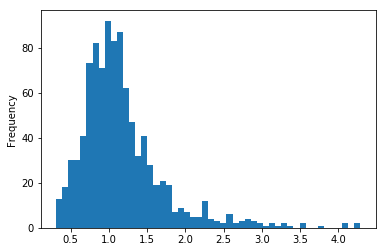

In [24]:
df = dataset[dataset['thickness'] == 6]
df['APPROX_BEND_COST'].plot.hist(bins=50)
plt.show()

## Target review

In [25]:
#Dataset definition
X = dataset
y = dataset[['VAMAT', 'VALAJOUT', 'VALTOT']]

,VALAJOUT
count,4316.000000
mean,2.840461
std,2.111223
min,0.220000
25%,1.490000
50%,2.365000
75%,3.570000
max,36.660000


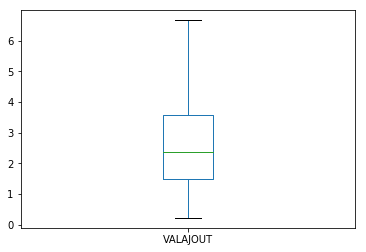

In [26]:
y[[target]].plot.box(sym='')
y[[target]].describe()

# Dataset re-ordering and Splitting

In [27]:
limitedset = ['cut_length', 'num_closed_patterns', 'num_open_patterns', 'total_area', 'minimum_rectangle_area',
              'minimum_rectangle_dim1', 'minimum_rectangle_dim2', 'convex_hull_area', 'no_hole_area', 'weight']

# 1 Bend as a float
limitedset.append('thickness')

# 2 Thickness as categories
#limitedset.extend([x for x in dataset.columns.values if x.startswith('thick_')])

# 3 Different counts
limitedset.extend(['radius_count', 'direction_count', 'bend_count'])

# 4 Bends in groups
#limitedset.extend([x for x in dataset.columns.values if x.startswith('bend_gr_')])

# 5 bends according DXF
#limitedset.extend([x for x in dataset.columns.values if x.startswith('benddxf_')])

# 6 according DXF, sorted by length
if target != 'VAMAT':
    limitedset.extend([x for x in dataset.columns.values if x.startswith('bendlength_')])


print(len(limitedset))
limitedset

144


['cut_length',
 'num_closed_patterns',
 'num_open_patterns',
 'total_area',
 'minimum_rectangle_area',
 'minimum_rectangle_dim1',
 'minimum_rectangle_dim2',
 'convex_hull_area',
 'no_hole_area',
 'weight',
 'thickness',
 'radius_count',
 'direction_count',
 'bend_count',
 'bendlength_bend_radius_00',
 'bendlength_bend_angle_00',
 'bendlength_bend_direction_00',
 'bendlength_deformation_length_00',
 'bendlength_merged_bend_00',
 'bendlength_punch_length_00',
 'bendlength_bend_radius_01',
 'bendlength_bend_angle_01',
 'bendlength_bend_direction_01',
 'bendlength_deformation_length_01',
 'bendlength_merged_bend_01',
 'bendlength_punch_length_01',
 'bendlength_bend_radius_02',
 'bendlength_bend_angle_02',
 'bendlength_bend_direction_02',
 'bendlength_deformation_length_02',
 'bendlength_merged_bend_02',
 'bendlength_punch_length_02',
 'bendlength_bend_radius_03',
 'bendlength_bend_angle_03',
 'bendlength_bend_direction_03',
 'bendlength_deformation_length_03',
 'bendlength_merged_bend_03',

In [28]:
# Dataset splitting
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0 ,stratify=dataset['bend_group'])

print(X_train.shape, X_test.shape)

#ONLY FOR DATASET CLEANING PURPOSE
#X_test, X_train, y_test, y_train = train_test_split(X, y, test_size=0.5, random_state=0 ,stratify=dataset['bend_group'])

(3021, 668) (1295, 668)


# Box_cox feature creation

In [29]:
from scipy import stats
from scipy.special import inv_boxcox
_, lmbda = stats.boxcox(y_train[target], lmbda=None)
y_train['logtarget'] = y_train[target].apply(lambda x: stats.boxcox(x, lmbda))
y_test['logtarget'] = y_test[target].apply(lambda x: stats.boxcox(x, lmbda))

/Users/cricket/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/cricket/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


# Blocs creation

In [30]:
#Scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [31]:
# Metric MSE
from sklearn.metrics import mean_squared_error

In [32]:
# Metric MAE
from sklearn.metrics import mean_absolute_error

In [33]:
# Metric MAPE Mean absolute percentage error
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

from sklearn.metrics import make_scorer
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)
mape_scorer

make_scorer(mean_absolute_percentage_error, greater_is_better=False)

In [34]:
#regressions
import lightgbm as lgb

gbm = lgb.LGBMRegressor(objective='regression',
                        n_estimators=200,
                        random_state=0,
                       )

In [35]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [36]:
#Pipe definition
pipe = [('scaler', scaler), ('gbm', gbm)]

# Direct prediction

In [37]:
regpip = Pipeline(pipe)

In [38]:
regpip.fit(X_train[limitedset], y_train[target])

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('gbm', LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.1, max_depth=-1, min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=200,
       n_jobs=-1, num_leaves=31, objective='regression', random_state=0,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=1))])

In [39]:
param_grid = {
    'gbm__num_leaves':[20, 30, 40],
    #'gbm__min_child_weight':np.logspace(-3,1,5),
    'gbm__min_data_in_leaf':[20,30,10],
    
    }

#MSE version
gridgbm = GridSearchCV(regpip, param_grid, cv=3, n_jobs=-2, scoring='neg_mean_squared_error', verbose=5)

#gridgbm = GridSearchCV(regpip, param_grid, cv=3, n_jobs=-2, scoring={'mse':'neg_mean_squared_error', 'mape':mape_scorer}, verbose=5, refit='mse')


#MAPE version
#gridgbm = GridSearchCV(regpip, param_grid, cv=3, n_jobs=-2, scoring=mape_scorer, verbose=2)

In [40]:
gridgbm.fit(X_train[limitedset], y_train[target])

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] gbm__min_data_in_leaf=20, gbm__num_leaves=20 ....................
[CV] gbm__min_data_in_leaf=20, gbm__num_leaves=20 ....................
[CV] gbm__min_data_in_leaf=20, gbm__num_leaves=20 ....................
[CV]  gbm__min_data_in_leaf=20, gbm__num_leaves=20, score=-0.6870680255396255, total=   1.9s
[CV] gbm__min_data_in_leaf=20, gbm__num_leaves=30 ....................
[CV]  gbm__min_data_in_leaf=20, gbm__num_leaves=20, score=-1.019860880872779, total=   2.3s
[CV] gbm__min_data_in_leaf=20, gbm__num_leaves=30 ....................
[CV]  gbm__min_data_in_leaf=20, gbm__num_leaves=20, score=-1.20145130210212, total=   2.8s
[CV] gbm__min_data_in_leaf=20, gbm__num_leaves=30 ....................
[CV]  gbm__min_data_in_leaf=20, gbm__num_leaves=30, score=-0.7062542448246558, total=   2.5s
[CV] gbm__min_data_in_leaf=20, gbm__num_leaves=40 ....................
[CV]  gbm__min_data_in_leaf=20, gbm__num_leaves=30, score=-1.0615269315280

[Parallel(n_jobs=-2)]: Done  12 tasks      | elapsed:   13.7s


[CV]  gbm__min_data_in_leaf=30, gbm__num_leaves=30, score=-0.7752141512598938, total=   2.6s
[CV] gbm__min_data_in_leaf=30, gbm__num_leaves=40 ....................
[CV]  gbm__min_data_in_leaf=30, gbm__num_leaves=30, score=-1.2666267542541139, total=   4.3s
[CV] gbm__min_data_in_leaf=30, gbm__num_leaves=40 ....................
[CV]  gbm__min_data_in_leaf=30, gbm__num_leaves=30, score=-0.943136214010894, total=   3.5s
[CV] gbm__min_data_in_leaf=30, gbm__num_leaves=40 ....................
[CV]  gbm__min_data_in_leaf=30, gbm__num_leaves=40, score=-0.7748265123955476, total=   3.3s
[CV] gbm__min_data_in_leaf=10, gbm__num_leaves=20 ....................
[CV]  gbm__min_data_in_leaf=30, gbm__num_leaves=40, score=-0.9547321957638861, total=   4.3s
[CV] gbm__min_data_in_leaf=10, gbm__num_leaves=20 ....................
[CV]  gbm__min_data_in_leaf=30, gbm__num_leaves=40, score=-1.2612488496518504, total=   5.5s
[CV] gbm__min_data_in_leaf=10, gbm__num_leaves=20 ....................
[CV]  gbm__min_da

[Parallel(n_jobs=-2)]: Done  27 out of  27 | elapsed:   32.3s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('gbm', LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.1, max_depth=-1, min_child_samples=20,
       min_child_weight=0.001, min_spli...0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=1))]),
       fit_params=None, iid=True, n_jobs=-2,
       param_grid={'gbm__num_leaves': [20, 30, 40], 'gbm__min_data_in_leaf': [20, 30, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=5)

In [41]:
print('target        :', target)
print('best score    :', gridgbm.best_score_)
print('best params   :', gridgbm.best_params_)
mapetest=mean_absolute_percentage_error(y_test[target], gridgbm.predict(X_test[limitedset]))
print('MAPE test set :', mapetest)
msetest = mean_squared_error(y_test[target], gridgbm.predict(X_test[limitedset]))
print('MSE  test set :', msetest)
msetrain = mean_squared_error(y_train[target], gridgbm.predict(X_train[limitedset]))
print('MSE train set :', msetrain)


target        : VALAJOUT
best score    : -0.8596531390827422
best params   : {'gbm__min_data_in_leaf': 10, 'gbm__num_leaves': 20}
MAPE test set : 20.005697547111478
MSE  test set : 0.9701343608497809
MSE train set : 0.1425192155148782


## Hyperopt

In [42]:
from hyperopt import hp, tpe
from hyperopt.fmin import fmin
from sklearn.model_selection import cross_val_score

In [43]:
def objective(params):
    params = {
        'num_leaves': int(params['num_leaves']),
        'min_data_in_leaf': int(params['min_data_in_leaf']),
        'min_child_weight': params['min_child_weight'],
        #'n_estimators': int(params['n_estimators']),
        'colsample_bytree': params['colsample_bytree'],
        'bagging_fraction': params['bagging_fraction'],
        'bagging_freq': params['bagging_freq'],
        'reg_alpha': params['reg_alpha'],
        'reg_lambda': params['reg_lambda'],
        'max_depth':int(params['max_depth']),
        'learning_rate':params['learning_rate'],
        }
    
    clf = lgb.LGBMRegressor(objective='regression', n_estimators=200, **params)

    pipe = [('scaler', scaler), ('xgb', clf)]
    regpip = Pipeline(pipe)    
    
    score = cross_val_score(regpip, X_train[limitedset], y_train[target], scoring='neg_mean_squared_error', cv=3, n_jobs=-2).mean()
    print("MSE {:.3f} - params {}".format(score, params))
    return -score

space = {
    'num_leaves': hp.uniform('num_leaves', 5, 40),
    'min_data_in_leaf': hp.uniform('min_data_in_leaf',10, 40),
    'min_child_weight': hp.uniform('min_child_weight', 0.001, 20),
    #'n_estimators': hp.uniform('n_estimators', 100, 500),
    'colsample_bytree': hp.uniform('colsample_bytree', 0., 1.0),
    'bagging_fraction': hp.uniform('bagging_fraction', 0., 1.0),
    'bagging_freq': hp.randint('bagging_freq', 15),
    'reg_alpha': hp.loguniform('reg_alpha', -3, 3),
    'reg_lambda': hp.loguniform('reg_lambda', -3, 3),
    'max_depth': hp.uniform('max_depth', 3, 15),
    'learning_rate': hp.uniform('learning_rate', 0.001, .1),
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50)

MSE -1.042 - params {'num_leaves': 9, 'min_data_in_leaf': 24, 'min_child_weight': 12.575767431653167, 'colsample_bytree': 0.05923354541189718, 'bagging_fraction': 0.7156467960265287, 'bagging_freq': 4, 'reg_alpha': 0.20839285060130075, 'reg_lambda': 14.187812701751774, 'max_depth': 4, 'learning_rate': 0.07521879301145194}
MSE -0.950 - params {'num_leaves': 29, 'min_data_in_leaf': 14, 'min_child_weight': 8.527148594391013, 'colsample_bytree': 0.7413641081170684, 'bagging_fraction': 0.6347947360492598, 'bagging_freq': 1, 'reg_alpha': 2.942703637982676, 'reg_lambda': 16.347335940643703, 'max_depth': 11, 'learning_rate': 0.03193652968080187}
MSE -1.012 - params {'num_leaves': 22, 'min_data_in_leaf': 22, 'min_child_weight': 15.24361857865299, 'colsample_bytree': 0.48748935562983153, 'bagging_fraction': 0.48774678342774214, 'bagging_freq': 1, 'reg_alpha': 0.21802592664172726, 'reg_lambda': 1.1147706752791555, 'max_depth': 14, 'learning_rate': 0.017770186125554734}
MSE -1.612 - params {'num_l

MSE -0.906 - params {'num_leaves': 39, 'min_data_in_leaf': 13, 'min_child_weight': 11.94722404639681, 'colsample_bytree': 0.2145310911025774, 'bagging_fraction': 0.7738722528871751, 'bagging_freq': 13, 'reg_alpha': 1.1576447719979306, 'reg_lambda': 0.4047737422798561, 'max_depth': 9, 'learning_rate': 0.04242169712506115}
MSE -0.892 - params {'num_leaves': 39, 'min_data_in_leaf': 12, 'min_child_weight': 11.537095053258357, 'colsample_bytree': 0.20948037931145835, 'bagging_fraction': 0.9316345074594645, 'bagging_freq': 13, 'reg_alpha': 1.448866959857258, 'reg_lambda': 0.37054570586017815, 'max_depth': 9, 'learning_rate': 0.06025130579607989}
MSE -0.886 - params {'num_leaves': 34, 'min_data_in_leaf': 11, 'min_child_weight': 11.543597682990503, 'colsample_bytree': 0.4083949685714451, 'bagging_fraction': 0.9216381518782222, 'bagging_freq': 13, 'reg_alpha': 1.3821346511491845, 'reg_lambda': 0.10303212565443011, 'max_depth': 9, 'learning_rate': 0.058977108115590524}
MSE -0.936 - params {'num_

In [44]:
params = {
        'num_leaves': int(best['num_leaves']),
        'min_data_in_leaf': int(best['min_data_in_leaf']),
        'min_child_weight': best['min_child_weight'],
        #'n_estimators': int(best['n_estimators']),
        'colsample_bytree': best['colsample_bytree'],
        'bagging_fraction': best['bagging_fraction'],
        'bagging_freq': best['bagging_freq'],
        'reg_alpha': best['reg_alpha'],
        'reg_lambda': best['reg_lambda'],
        'max_depth':int(best['max_depth']),
        'learning_rate':best['learning_rate'],
        }

clf = lgb.LGBMRegressor(objective='regression', n_estimators=200, **params)
pipe = [('scaler', scaler), ('gbm', clf)]
regpip = Pipeline(pipe)
regpip.fit(X_train[limitedset], y_train[target])

preds = regpip.predict(X_test[limitedset])

msetest = mean_squared_error(y_test[target], preds)
mapetest = mean_absolute_percentage_error(y_test[target], preds)
msetrain = mean_squared_error(y_train[target], regpip.predict(X_train[limitedset]))
print(target)
#print(clf.get_params())
print(params)
print('MAPE test:', mapetest)
print('MSE  test:', msetest)
print('MSE train:', msetrain)


VALAJOUT
{'num_leaves': 25, 'min_data_in_leaf': 14, 'min_child_weight': 0.05553282522163272, 'colsample_bytree': 0.837034263171514, 'bagging_fraction': 0.9102328537197719, 'bagging_freq': 6, 'reg_alpha': 4.956636182389699, 'reg_lambda': 1.4791555841538824, 'max_depth': 8, 'learning_rate': 0.07116251531914825}
MAPE test: 20.127788059222897
MSE  test: 0.652012839977643
MSE train: 0.2710369127074588


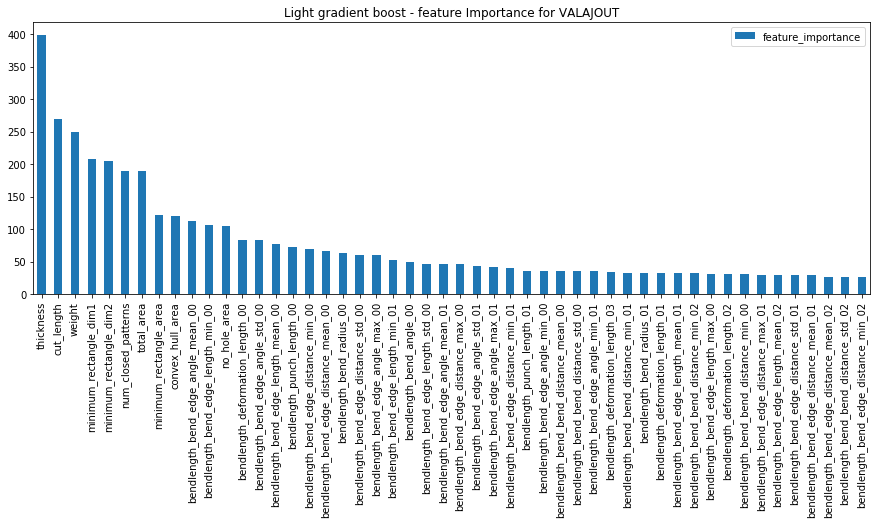

In [45]:
featimp = list(regpip.named_steps['gbm'].feature_importances_)
df = pd.DataFrame({'feature_importance':featimp}, index =limitedset)
df = df.sort_values('feature_importance', ascending=False)
df[:50].plot.bar(figsize=(15,5))
plt.title(f'Light gradient boost - feature Importance for {target}')
plt.show()

# BOX-COX prediction

In [46]:
gbmlog = lgb.LGBMRegressor(objective='regression',
                        n_estimators=200,
                        random_state=0,
                       )
pipe = [('scaler', scaler), ('gbm', gbmlog)]
regpiplog = Pipeline(pipe)

In [47]:
regpiplog.fit(X_train[limitedset], y_train['logtarget'])

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('gbm', LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.1, max_depth=-1, min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=200,
       n_jobs=-1, num_leaves=31, objective='regression', random_state=0,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=1))])

In [48]:
param_grid = {
    'gbm__num_leaves':[20, 30, 40],
    'gbm__min_child_weight':np.logspace(-3,1,5),
    'gbm__min_data_in_leaf':[20,30,10],
    }

#MAE version
gridgbmlog = GridSearchCV(regpiplog, param_grid, cv=3, n_jobs=-2, scoring='neg_mean_absolute_error', verbose=5)

#MAPE version
#gridgbmlog = GridSearchCV(regpiplog, param_grid, cv=3, n_jobs=-2, scoring=mape_scorer, verbose=2)

In [49]:
%%time
gridgbmlog.fit(X_train[limitedset], y_train['logtarget'])

Fitting 3 folds for each of 45 candidates, totalling 135 fits
[CV] gbm__min_child_weight=0.001, gbm__min_data_in_leaf=20, gbm__num_leaves=20 
[CV] gbm__min_child_weight=0.001, gbm__min_data_in_leaf=20, gbm__num_leaves=20 
[CV] gbm__min_child_weight=0.001, gbm__min_data_in_leaf=20, gbm__num_leaves=20 
[CV]  gbm__min_child_weight=0.001, gbm__min_data_in_leaf=20, gbm__num_leaves=20, score=-0.18810459389705142, total=   0.8s
[CV] gbm__min_child_weight=0.001, gbm__min_data_in_leaf=20, gbm__num_leaves=30 
[CV]  gbm__min_child_weight=0.001, gbm__min_data_in_leaf=20, gbm__num_leaves=20, score=-0.18703496101415834, total=   1.8s
[CV] gbm__min_child_weight=0.001, gbm__min_data_in_leaf=20, gbm__num_leaves=30 
[CV]  gbm__min_child_weight=0.001, gbm__min_data_in_leaf=20, gbm__num_leaves=20, score=-0.184943013471214, total=   2.1s
[CV] gbm__min_child_weight=0.001, gbm__min_data_in_leaf=20, gbm__num_leaves=30 
[CV]  gbm__min_child_weight=0.001, gbm__min_data_in_leaf=20, gbm__num_leaves=30, score=-0.1

[Parallel(n_jobs=-2)]: Done  12 tasks      | elapsed:   13.3s


[CV] gbm__min_child_weight=0.001, gbm__min_data_in_leaf=30, gbm__num_leaves=30 
[CV] gbm__min_child_weight=0.001, gbm__min_data_in_leaf=30, gbm__num_leaves=30 
[CV] gbm__min_child_weight=0.001, gbm__min_data_in_leaf=30, gbm__num_leaves=30 
[CV]  gbm__min_child_weight=0.001, gbm__min_data_in_leaf=30, gbm__num_leaves=30, score=-0.19290733102530397, total=   2.2s
[CV] gbm__min_child_weight=0.001, gbm__min_data_in_leaf=30, gbm__num_leaves=40 
[CV]  gbm__min_child_weight=0.001, gbm__min_data_in_leaf=30, gbm__num_leaves=30, score=-0.18972722686048368, total=   2.9s
[CV] gbm__min_child_weight=0.001, gbm__min_data_in_leaf=30, gbm__num_leaves=40 
[CV]  gbm__min_child_weight=0.001, gbm__min_data_in_leaf=30, gbm__num_leaves=30, score=-0.18798405946549843, total=   3.1s
[CV] gbm__min_child_weight=0.001, gbm__min_data_in_leaf=30, gbm__num_leaves=40 
[CV]  gbm__min_child_weight=0.001, gbm__min_data_in_leaf=30, gbm__num_leaves=40, score=-0.19113048071552408, total=   3.1s
[CV]  gbm__min_child_weight=

[CV] gbm__min_child_weight=0.1, gbm__min_data_in_leaf=20, gbm__num_leaves=20 
[CV]  gbm__min_child_weight=0.01, gbm__min_data_in_leaf=10, gbm__num_leaves=40, score=-0.18984594449120518, total=   4.6s
[CV] gbm__min_child_weight=0.1, gbm__min_data_in_leaf=20, gbm__num_leaves=20 
[CV]  gbm__min_child_weight=0.01, gbm__min_data_in_leaf=10, gbm__num_leaves=40, score=-0.18951158652059769, total=   4.3s
[CV] gbm__min_child_weight=0.1, gbm__min_data_in_leaf=20, gbm__num_leaves=20 
[CV]  gbm__min_child_weight=0.1, gbm__min_data_in_leaf=20, gbm__num_leaves=20, score=-0.18703496101415834, total=   2.1s
[CV] gbm__min_child_weight=0.1, gbm__min_data_in_leaf=20, gbm__num_leaves=30 
[CV]  gbm__min_child_weight=0.1, gbm__min_data_in_leaf=20, gbm__num_leaves=20, score=-0.18810459389705142, total=   2.9s
[CV] gbm__min_child_weight=0.1, gbm__min_data_in_leaf=20, gbm__num_leaves=30 
[CV]  gbm__min_child_weight=0.1, gbm__min_data_in_leaf=20, gbm__num_leaves=20, score=-0.184943013471214, total=   2.1s
[CV] 

[Parallel(n_jobs=-2)]: Done  66 tasks      | elapsed:  1.3min


[CV]  gbm__min_child_weight=0.1, gbm__min_data_in_leaf=30, gbm__num_leaves=30, score=-0.18798405946549843, total=   2.6s
[CV] gbm__min_child_weight=0.1, gbm__min_data_in_leaf=30, gbm__num_leaves=40 
[CV]  gbm__min_child_weight=0.1, gbm__min_data_in_leaf=30, gbm__num_leaves=30, score=-0.18972722686048368, total=   3.3s
[CV] gbm__min_child_weight=0.1, gbm__min_data_in_leaf=30, gbm__num_leaves=40 
[CV]  gbm__min_child_weight=0.1, gbm__min_data_in_leaf=30, gbm__num_leaves=30, score=-0.19290733102530397, total=   4.0s
[CV] gbm__min_child_weight=0.1, gbm__min_data_in_leaf=30, gbm__num_leaves=40 
[CV]  gbm__min_child_weight=0.1, gbm__min_data_in_leaf=30, gbm__num_leaves=40, score=-0.19113048071552408, total=   3.3s
[CV] gbm__min_child_weight=0.1, gbm__min_data_in_leaf=10, gbm__num_leaves=20 
[CV]  gbm__min_child_weight=0.1, gbm__min_data_in_leaf=30, gbm__num_leaves=40, score=-0.18980195414664078, total=   4.2s
[CV] gbm__min_child_weight=0.1, gbm__min_data_in_leaf=10, gbm__num_leaves=20 
[CV] 

[CV] gbm__min_child_weight=10.0, gbm__min_data_in_leaf=20, gbm__num_leaves=20 
[CV]  gbm__min_child_weight=10.0, gbm__min_data_in_leaf=20, gbm__num_leaves=20, score=-0.18810459389705142, total=   2.6s
[CV] gbm__min_child_weight=10.0, gbm__min_data_in_leaf=20, gbm__num_leaves=30 
[CV]  gbm__min_child_weight=10.0, gbm__min_data_in_leaf=20, gbm__num_leaves=20, score=-0.18703496101415834, total=   2.2s
[CV] gbm__min_child_weight=10.0, gbm__min_data_in_leaf=20, gbm__num_leaves=30 
[CV]  gbm__min_child_weight=10.0, gbm__min_data_in_leaf=20, gbm__num_leaves=20, score=-0.184943013471214, total=   2.1s
[CV] gbm__min_child_weight=10.0, gbm__min_data_in_leaf=20, gbm__num_leaves=30 
[CV]  gbm__min_child_weight=10.0, gbm__min_data_in_leaf=20, gbm__num_leaves=30, score=-0.1879712427334959, total=   2.6s
[CV] gbm__min_child_weight=10.0, gbm__min_data_in_leaf=20, gbm__num_leaves=40 
[CV]  gbm__min_child_weight=10.0, gbm__min_data_in_leaf=20, gbm__num_leaves=30, score=-0.1895754150727624, total=   3.5s

[Parallel(n_jobs=-2)]: Done 135 out of 135 | elapsed:  2.7min finished


CPU times: user 3.62 s, sys: 259 ms, total: 3.88 s
Wall time: 2min 45s


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('gbm', LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.1, max_depth=-1, min_child_samples=20,
       min_child_weight=0.001, min_spli...0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=1))]),
       fit_params=None, iid=True, n_jobs=-2,
       param_grid={'gbm__num_leaves': [20, 30, 40], 'gbm__min_child_weight': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01]), 'gbm__min_data_in_leaf': [20, 30, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=5)

In [50]:
print('target        :', target)
print('best score    :', gridgbmlog.best_score_)
print('best params   :', gridgbmlog.best_params_)
mapetest=mean_absolute_percentage_error(y_test[target], inv_boxcox(gridgbmlog.predict(X_test[limitedset]), lmbda))
print('MAPE test set :', mapetest)
msetest = mean_squared_error(y_test[target], inv_boxcox(gridgbmlog.predict(X_test[limitedset]), lmbda))
print('MSE  test set :', msetest)
msetrain = mean_squared_error(y_train[target], inv_boxcox(gridgbmlog.predict(X_train[limitedset]), lmbda))
print('MSE train set :', msetrain)

target        : VALAJOUT
best score    : -0.18528573789331257
best params   : {'gbm__min_child_weight': 10.0, 'gbm__min_data_in_leaf': 10, 'gbm__num_leaves': 20}
MAPE test set : 18.974967192436978
MSE  test set : 0.5728523357733593
MSE train set : 0.15893339456849942


In [51]:
def objective(params):
    params = {
        'num_leaves': int(params['num_leaves']),
        'min_data_in_leaf': int(params['min_data_in_leaf']),
        'min_child_weight': params['min_child_weight'],
        #'n_estimators': int(params['n_estimators']),
        'colsample_bytree': params['colsample_bytree'],
        'bagging_fraction': params['bagging_fraction'],
        'bagging_freq': params['bagging_freq'],
        'reg_alpha': params['reg_alpha'],
        'reg_lambda': params['reg_lambda'],
        'max_depth':int(params['max_depth']),
        'learning_rate':params['learning_rate'],
        }
    
    clf = lgb.LGBMRegressor(objective='regression', n_estimators=200, **params)

    pipe = [('scaler', scaler), ('gbm', clf)]
    regpip = Pipeline(pipe)    
    
    score = cross_val_score(regpip, X_train[limitedset], y_train['logtarget'], scoring='neg_mean_absolute_error', cv=3, n_jobs=-2).mean()
    print("MSE {:.3f} - params {}".format(score, params))
    return -score

space = {
    'num_leaves': hp.uniform('num_leaves', 5, 40),
    'min_data_in_leaf': hp.uniform('min_data_in_leaf', 5, 20),
    'min_child_weight': hp.uniform('min_child_weight', 0.001, 20),
    #'n_estimators': hp.uniform('n_estimators', 100, 500),
    'colsample_bytree': hp.uniform('colsample_bytree', 0., 1.0),
    'bagging_fraction': hp.uniform('bagging_fraction', 0., 1.0),
    'bagging_freq': hp.randint('bagging_freq', 15),
    'reg_alpha': hp.loguniform('reg_alpha', -3, 3),
    'reg_lambda': hp.loguniform('reg_lambda', -3, 3),
    'max_depth': hp.uniform('max_depth', 3, 15),
    'learning_rate': hp.uniform('learning_rate', 0.001, .1),
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50)

MSE -0.224 - params {'num_leaves': 33, 'min_data_in_leaf': 11, 'min_child_weight': 6.830833608147054, 'colsample_bytree': 0.5937022410483523, 'bagging_fraction': 0.11600975701654126, 'bagging_freq': 4, 'reg_alpha': 5.4892146290970265, 'reg_lambda': 13.502160609115672, 'max_depth': 5, 'learning_rate': 0.08337767719070606}
MSE -0.187 - params {'num_leaves': 15, 'min_data_in_leaf': 14, 'min_child_weight': 1.8003760829098443, 'colsample_bytree': 0.3586824062813906, 'bagging_fraction': 0.40328008676675875, 'bagging_freq': 6, 'reg_alpha': 0.07093431290847739, 'reg_lambda': 2.3352054348682714, 'max_depth': 9, 'learning_rate': 0.08360576151105616}
MSE -0.245 - params {'num_leaves': 6, 'min_data_in_leaf': 15, 'min_child_weight': 11.1507138555663, 'colsample_bytree': 0.1480463883543982, 'bagging_fraction': 0.4935669413143813, 'bagging_freq': 9, 'reg_alpha': 0.16046616307908473, 'reg_lambda': 4.7281614591345384, 'max_depth': 3, 'learning_rate': 0.011833332919159261}
MSE -0.199 - params {'num_leav

MSE -0.185 - params {'num_leaves': 10, 'min_data_in_leaf': 13, 'min_child_weight': 5.445131425541559, 'colsample_bytree': 0.9960522656174529, 'bagging_fraction': 0.8506837218544812, 'bagging_freq': 0, 'reg_alpha': 2.4152932215061456, 'reg_lambda': 0.5064136139234381, 'max_depth': 11, 'learning_rate': 0.050176688854159573}
MSE -0.184 - params {'num_leaves': 15, 'min_data_in_leaf': 18, 'min_child_weight': 8.213314473197638, 'colsample_bytree': 0.8751737542994368, 'bagging_fraction': 0.8655765729722833, 'bagging_freq': 0, 'reg_alpha': 0.41694634618708626, 'reg_lambda': 0.11421539240342594, 'max_depth': 14, 'learning_rate': 0.0727200734265632}
MSE -0.185 - params {'num_leaves': 9, 'min_data_in_leaf': 16, 'min_child_weight': 0.3683180974644351, 'colsample_bytree': 0.4428306920651886, 'bagging_fraction': 0.9945758188911009, 'bagging_freq': 8, 'reg_alpha': 0.1903411973370808, 'reg_lambda': 0.3068777371085537, 'max_depth': 11, 'learning_rate': 0.037290301050454326}
MSE -0.183 - params {'num_le

In [52]:
%%time
params = {
        'num_leaves': int(best['num_leaves']),
        'min_data_in_leaf': int(best['min_data_in_leaf']),
        'min_child_weight': best['min_child_weight'],
        #'n_estimators': int(best['n_estimators']),
        'colsample_bytree': best['colsample_bytree'],
        'bagging_fraction': best['bagging_fraction'],
        'bagging_freq': best['bagging_freq'],
        'reg_alpha': best['reg_alpha'],
        'reg_lambda': best['reg_lambda'],
        'max_depth':int(best['max_depth']),
        'learning_rate':best['learning_rate'],
        }

clflog = lgb.LGBMRegressor(objective='regression', n_estimators=200, **params)
pipe = [('scaler', scaler), ('gbm', clflog)]
regpiplog = Pipeline(pipe)
regpiplog.fit(X_train[limitedset], y_train['logtarget'])

preds = inv_boxcox(regpiplog.predict(X_test[limitedset]), lmbda)

msetest = mean_squared_error(y_test[target], preds)
mapetest = mean_absolute_percentage_error(y_test[target], preds)
msetrain = mean_squared_error(y_train[target], inv_boxcox(regpiplog.predict(X_train[limitedset]), lmbda))
print(target)
#print(clf.get_params())
print(params)
print('MAPE test:', mapetest)
print('MSE  test:', msetest)
print('MSE train:', msetrain)

VALAJOUT
{'num_leaves': 12, 'min_data_in_leaf': 13, 'min_child_weight': 5.646762568521276, 'colsample_bytree': 0.8941676808058135, 'bagging_fraction': 0.8451701714604745, 'bagging_freq': 0, 'reg_alpha': 0.3392118876460649, 'reg_lambda': 0.3672891750059485, 'max_depth': 11, 'learning_rate': 0.0692801132553571}
MAPE test: 19.28721563950718
MSE  test: 0.6028239218327394
MSE train: 0.3378563934337164
CPU times: user 1.43 s, sys: 35.7 ms, total: 1.47 s
Wall time: 410 ms


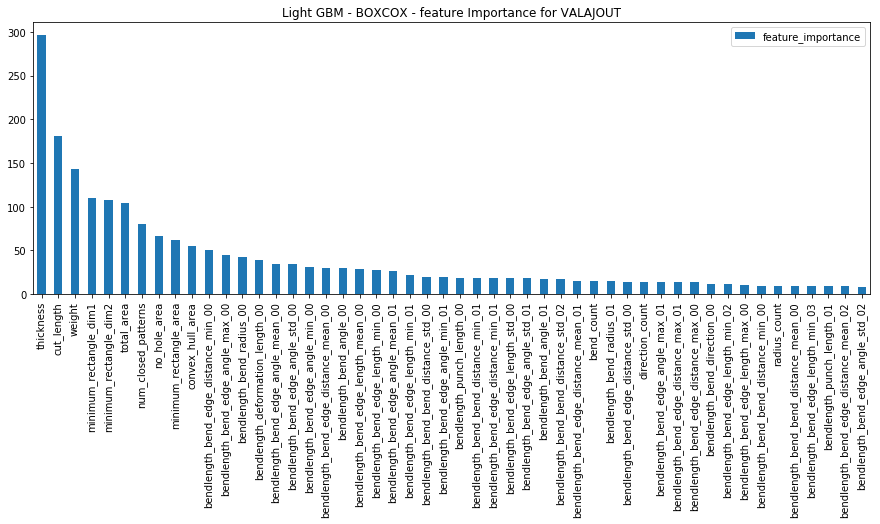

In [53]:
featimp = list(regpiplog.named_steps['gbm'].feature_importances_)
df = pd.DataFrame({'feature_importance':featimp}, index =limitedset)
df = df.sort_values('feature_importance', ascending=False)
df[:50].plot.bar(figsize=(15,5))
plt.title(f'Light GBM - BOXCOX - feature Importance for {target}')
plt.show()

# Solution comparison

In [54]:
prediction_lgbm = gridgbm.predict(X_test[limitedset])
prediction_lgbm_log = inv_boxcox(gridgbmlog.predict(X_test[limitedset]), lmbda)

In [55]:
resultset = pd.DataFrame({f'target': y_test[target],
                          'pred_lgbm':prediction_lgbm,
                          'pred_lgbm_BOXCOX':prediction_lgbm_log,
                            }, index=y_test.index)
resultset.head()

,pred_lgbm,pred_lgbm_BOXCOX,target
COART,,,
L3104170,2.516238,2.584162,3.72
L8826140,1.939234,1.874523,1.98
L1615860,0.780215,0.601494,0.80
L8055440,2.291191,2.309718,2.55
L8042170,2.007750,1.840552,1.68


In [56]:
#Solution saving
resultset.to_csv(f'{target}_pred_lgbm.csv')


In [57]:
#MAPE
mape = mean_absolute_percentage_error(resultset['target'], resultset['pred_lgbm'])
mapelog = mean_absolute_percentage_error(resultset['target'], resultset['pred_lgbm_BOXCOX'])
print('mape', mape)
print('mapelog', mapelog)

mape 20.005697547111478
mapelog 18.974967192436978


In [58]:
#MSE
mse = mean_squared_error(resultset['target'], resultset['pred_lgbm'])
mselog = mean_squared_error(resultset['target'], resultset['pred_lgbm_BOXCOX'])
print('mse', mse)
print('mselog', mselog)

mse 0.9701343608497809
mselog 0.5728523357733593


In [59]:
resultset['MSE_lgbm'] = (resultset['target']-resultset['pred_lgbm'])**2
resultset['MSE_log_lgbm'] = (resultset['target']-resultset['pred_lgbm_BOXCOX'])**2
resultset.head()

,pred_lgbm,pred_lgbm_BOXCOX,target,MSE_lgbm,MSE_log_lgbm
COART,,,,,
L3104170,2.516238,2.584162,3.72,1.449044,1.290128
L8826140,1.939234,1.874523,1.98,0.001662,0.011125
L1615860,0.780215,0.601494,0.80,0.000391,0.039405
L8055440,2.291191,2.309718,2.55,0.066982,0.057735
L8042170,2.007750,1.840552,1.68,0.107420,0.025777


In [60]:
resultset['MSE_lgbm'].mean()

0.9701343608497804

In [61]:
#Data assembly
comparisonset = pd.merge(resultset.reset_index(), X_test.reset_index(), on='COART', how='inner')
comparisonset.head()

,COART,pred_lgbm,pred_lgbm_BOXCOX,target,MSE_lgbm,MSE_log_lgbm,cut_length,num_closed_patterns,num_open_patterns,total_area,...,VAMAT,VALAJOUT,VALTOT,VOL_COST_CONVHULL,VOL_COST_RECTANGLE,VOL_COST_MPATTERN,bend_group,SURF_COST_RECTANGLE,SURF_COST_MPATTERN,APPROX_BEND_COST
0,L3104170,2.516238,2.584162,3.72,1.449044,1.290128,1986.643677,10,0,61139.761719,...,4.41,3.72,8.13,0.000011,0.000008,0.000014,0,0.000038,0.000070,3.720
1,L8826140,1.939234,1.874523,1.98,0.001662,0.011125,496.880127,3,0,12029.566406,...,0.44,1.98,2.42,0.000006,0.000006,0.000006,1-2,0.000034,0.000036,0.990
2,L1615860,0.780215,0.601494,0.80,0.000391,0.039405,391.016144,2,0,4399.901855,...,0.24,0.80,1.04,0.000009,0.000007,0.000009,0,0.000036,0.000044,0.800
3,L8055440,2.291191,2.309718,2.55,0.066982,0.057735,776.781677,2,0,24182.181641,...,2.00,2.55,4.55,0.000008,0.000006,0.000008,1-2,0.000063,0.000079,1.275
4,L8042170,2.007750,1.840552,1.68,0.107420,0.025777,858.618835,2,0,27643.671875,...,2.06,1.68,3.74,0.000012,0.000010,0.000012,1-2,0.000062,0.000074,0.840


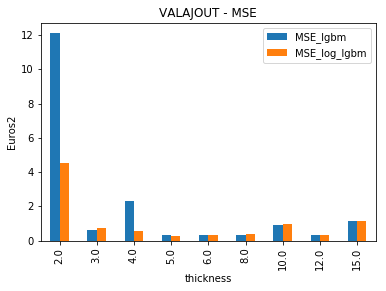

,MSE_lgbm,MSE_log_lgbm,COART
,mean,mean,count
thickness,,,
2.0,12.093936,4.502290,26
3.0,0.636272,0.709949,106
4.0,2.292890,0.546847,187
5.0,0.338486,0.285822,142
6.0,0.297259,0.295025,299
8.0,0.329608,0.358399,243
10.0,0.922872,0.952566,149
12.0,0.349794,0.332545,91


In [62]:
# Is the error sourced by thickness ?
df = comparisonset[['MSE_lgbm', 'MSE_log_lgbm', 'thickness']].groupby('thickness').mean()
df.plot.bar()
plt.title(f'{target} - MSE')
plt.ylabel('Euros2')
plt.show()
comparisonset.groupby('thickness').agg({'MSE_lgbm':['mean'],
                                         'MSE_log_lgbm':['mean'],
                                         'COART':['count']})

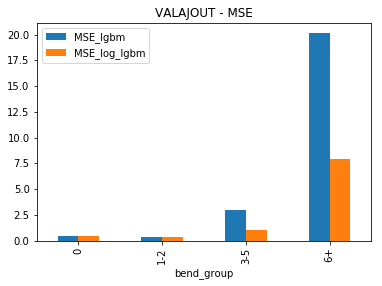

,MSE_lgbm,MSE_log_lgbm,COART
,mean,mean,count
bend_group,,,
0,0.447356,0.454044,535
1-2,0.314083,0.326170,579
3-5,3.007721,1.067171,164
6+,20.109913,7.944784,17


In [63]:
# Is the error sourced by number of bends ?

df = comparisonset[['MSE_lgbm', 'MSE_log_lgbm', 'bend_group']].groupby('bend_group').mean()
df.plot.bar()
plt.title(f'{target} - MSE')
plt.show()
comparisonset.groupby('bend_group').agg({'MSE_lgbm':['mean'],
                                         'MSE_log_lgbm':['mean'],
                                         'COART':['count']})

In [64]:
comparisonset['MAPE_error'] = comparisonset.apply(lambda x: mean_absolute_percentage_error(x['target'], x['pred_lgbm']), axis=1)
comparisonset['MAPE_log_error'] = comparisonset.apply(lambda x: mean_absolute_percentage_error(x['target'], x['pred_lgbm_BOXCOX']), axis=1)

comparisonset[['target', 'pred_lgbm', 'MAPE_error', 'pred_lgbm_BOXCOX', 'MAPE_log_error']].head()

,target,pred_lgbm,MAPE_error,pred_lgbm_BOXCOX,MAPE_log_error
0,3.72,2.516238,32.359201,2.584162,30.533286
1,1.98,1.939234,2.058870,1.874523,5.327111
2,0.80,0.780215,2.473160,0.601494,24.813233
3,2.55,2.291191,10.149360,2.309718,9.422806
4,1.68,2.007750,19.508937,1.840552,9.556646


In [65]:
#MAPE
comparisonset['MAPE_error'].mean()

20.00569754711147

In [66]:
#If bends use this line
if target == 'VALAJOUT' or target == 'VALTOT':
    df = comparisonset[['MSE_lgbm', 'MSE_log_lgbm','MAPE_error', 'MAPE_log_error', 'thickness', 'bend_group', 'COART']].groupby(['thickness', 'bend_group'])

#If no bends use this line
if target == 'VAMAT':
    df = comparisonset[['MSE_lgbm', 'MSE_log_lgbm','MAPE_error', 'MAPE_log_error', 'thickness', 'COART']].groupby(['thickness'])

perf = df.agg({'MSE_lgbm': ['mean', 'max'],
        'MSE_log_lgbm': ['mean', 'max'],
        'MAPE_error': ['mean', 'max'],
        'MAPE_log_error': ['mean', 'max'],
        'COART':['count'] })
perf

MSE_lgbm             MSE_log_lgbm             \
                           mean         max         mean        max   
thickness bend_group                                                  
2.0       1-2          0.257006    1.061070     0.237144   0.869426   
          3-5          0.920019    5.944953     1.194853   8.321734   
          6+          50.445348  268.202720    17.123264  67.466847   
3.0       0            0.297211    1.887737     0.290121   1.614103   
          1-2          0.189681    1.347665     0.170173   1.450659   
          3-5          0.664487   12.388028     1.005693  10.258840   
          6+           7.052132   13.692797     6.174899  10.432424   
4.0       0            0.357194    8.036516     0.320767   7.962614   
          1-2          0.171966    2.295222     0.153945   2.271987   
          3-5         10.031262  316.551912     1.781740  11.408656   
          6+           2.106135    4.579403     1.592847   3.581335   
5.0       0            0.258379    3.380421     0.237059   3.492845   
          1-2          0.304557    7.065681     0.285223   3.590688   
          3-5          0.517131    4.631405     0.309943   3.284900   
          6+           1.429432    4.255337     0.928047   2.540147   
6.0       0            0.104247    1.287528     0.094060   1.321119   
          1-2          0.318746    6.031653     0.368939   6.435275   
          3-5          0.792717    6.416371     0.612065   3.540344   
          6+           0.381199    0.381199     0.059467   0.059467   
8.0       0            0.401897    7.634885     0.408406   7.783774   
          1-2          0.212091    3.644653     0.241787   3.927555   
          3-5          0.442842    3.390213     0.648647   5.367122   
10.0      0            0.844396   22.736778     0.914613  24.419445   
          1-2          0.768822   10.785689     0.819855  11.547189   
          3-5          2.910609    6.757999     2.379560   8.398596   
12.0      0            0.309486    7.929664     0.315346   8.927454   
          1-2          0.440488    2.137290     0.371243   2.174118   
15.0      0            1.299534   31.859419     1.310999  32.819536   
          1-2          0.062429    0.173827     0.024266   0.062598   
          3-5          0.433248    0.433248     0.044401   0.044401   

                     MAPE_error             MAPE_log_error             COART  
                           mean         max           mean         max count  
thickness bend_group                                                          
2.0       1-2         24.660665  119.777057      22.611876   95.783733    10  
          3-5         13.028364   27.447543      14.366625   41.092832    10  
          6+          53.507873  254.299626      32.639141  127.543797     6  
3.0       0           32.355153  188.940778      28.179510  154.653996    26  
          1-2         16.552378  110.326409      16.411231  104.094692    40  
          3-5          9.078898   40.901813      13.381679   48.834606    36  
          6+          22.222080   25.388782      17.187817   27.868216     4  
4.0       0           30.953939   98.547306      27.410497   92.014443    34  
          1-2         17.635764  114.788816      16.307730  126.698445   111  
          3-5         30.669186  198.792244      27.038420  115.051934    39  
          6+          26.772184   36.962734      22.825242   30.510950     3  
5.0       0           43.186237  232.132697      36.941130  200.795595    47  
          1-2         18.607106  114.998445      18.356605  107.525555    75  
          3-5         10.262558   66.217533       9.339106   55.767053    17  
          6+           4.148625    9.889006       5.034840    7.640382     3  
6.0       0           22.219035  223.095300      21.847865  224.589568   112  
          1-2         15.962681  129.346176      16.716918  129.419489   149  
          3-5         18.594469   87.282252      16.895968  101.707038    37  
          6+        

In [67]:
perf.loc[2.]['MSE_lgbm', 'mean']


bend_group
1-2     0.257006
3-5     0.920019
6+     50.445348
Name: (MSE_lgbm, mean), dtype: float64

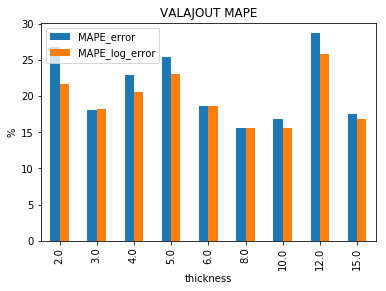

,MAPE_error,MAPE_log_error,COART
,mean,mean,count
thickness,,,
2.0,26.843751,21.754610,26
3.0,18.104318,18.298191,106
4.0,22.922024,20.668926,187
5.0,25.437996,23.146816,142
6.0,18.610449,18.617750,299
8.0,15.611903,15.596090,243
10.0,16.836594,15.624157,149
12.0,28.727995,25.837521,91


In [68]:
df = comparisonset[['MAPE_error', 'MAPE_log_error', 'thickness']].groupby('thickness').mean()
df.plot.bar()
plt.title(f'{target} MAPE')
plt.ylabel('%')
plt.show()
comparisonset.groupby('thickness').agg({'MAPE_error':['mean'],
                                         'MAPE_log_error':['mean'],
                                         'COART':['count']})

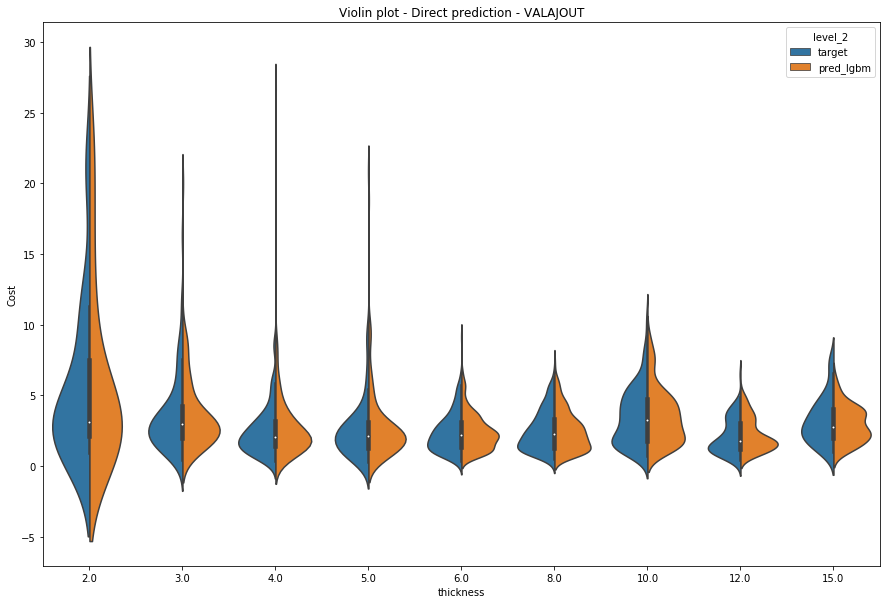

In [69]:
#Violin plot
df=comparisonset[['target', 'pred_lgbm', 'COART', 'thickness']]
#df=df[df['thickness']!=15]
df.set_index(['COART', 'thickness'], inplace=True)
df = df.stack().reset_index()
fig, ax = plt.subplots(figsize=(15,10))
#ax.set_ylim(-100, 100)
sns.violinplot(x="thickness", y=0, data=df, split=True, hue='level_2', ax=ax)
plt.title(f'Violin plot - Direct prediction - {target}')
plt.ylabel('Cost')
plt.show()

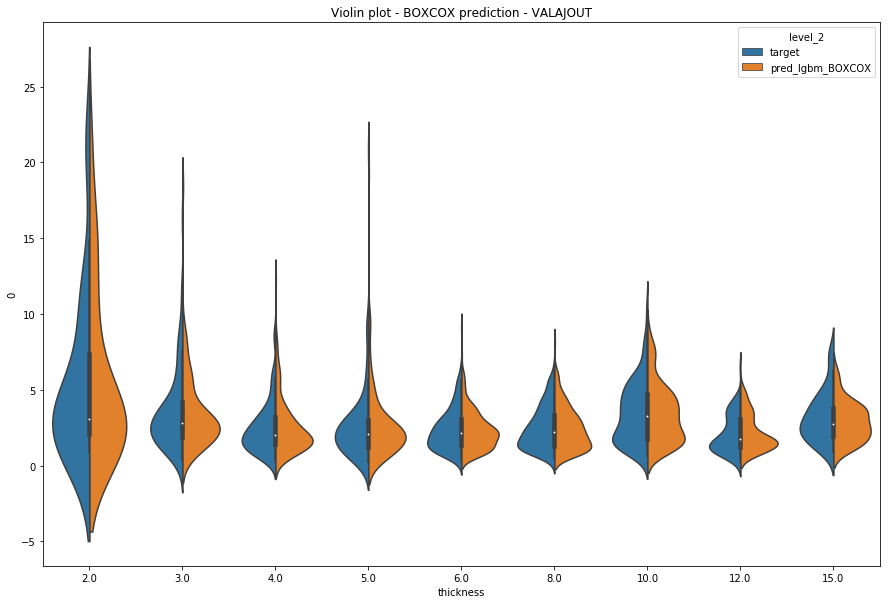

In [70]:
#Violin plot
df=comparisonset[['target', 'pred_lgbm_BOXCOX', 'COART', 'thickness']]
#df=df[df['thickness']!=15]
df.set_index(['COART', 'thickness'], inplace=True)
df = df.stack().reset_index()
fig, ax = plt.subplots(figsize=(15,10))
sns.violinplot(x="thickness", y=0, data=df, split=True, hue='level_2', ax=ax)
plt.title(f'Violin plot - BOXCOX prediction - {target}')
plt.show()

/Users/cricket/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


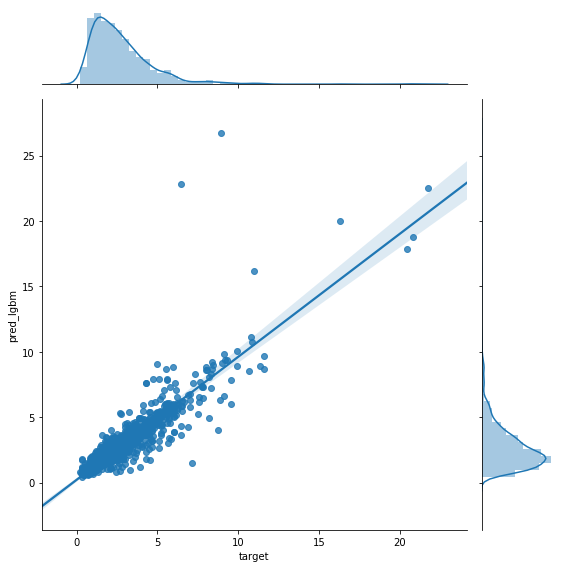

In [71]:
# No BOXCOX
sns.jointplot(x='target', y='pred_lgbm', data=comparisonset, kind='reg', size=8, stat_func=None)
plt.show()

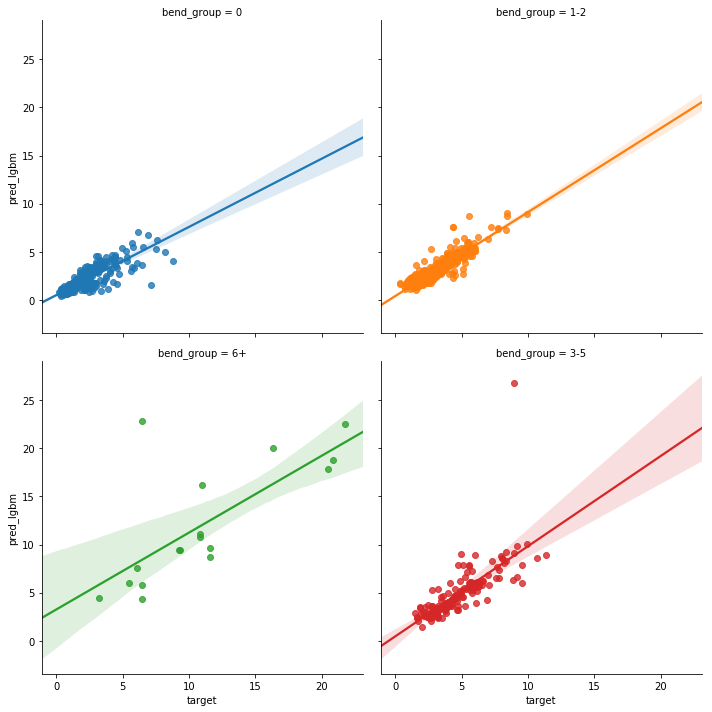

In [72]:
sns.lmplot(x='target',
           y='pred_lgbm',
           col='bend_group',
           hue='bend_group',
           data=comparisonset,
           aspect=1,
           col_wrap=2,
           size=5,
           legend=True)
plt.show()

/Users/cricket/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


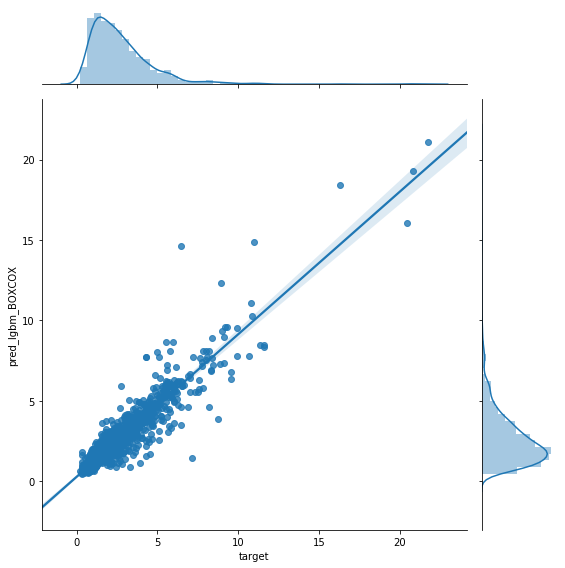

In [73]:
# With BOXCOX
sns.jointplot(x='target', y='pred_lgbm_BOXCOX', data=comparisonset, kind='reg',size=8, stat_func=None)
plt.show()

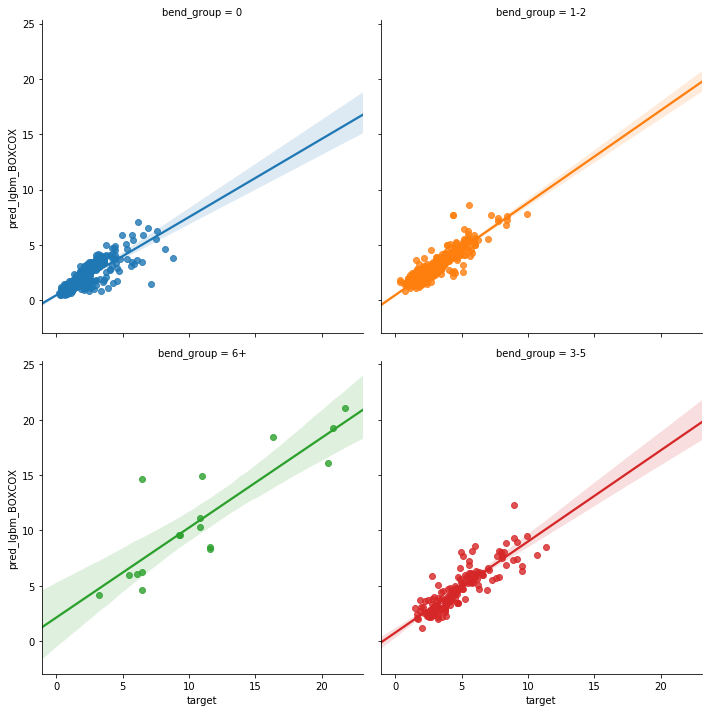

In [74]:
sns.lmplot(x='target',
           y='pred_lgbm_BOXCOX',
           col='bend_group',
           hue='bend_group',
           data=comparisonset,
           aspect=1,
           col_wrap=2,
           size=5,
           #palette="Set1",
           legend=True),
plt.show()

In [75]:
df = comparisonset[['MSE_lgbm', 'COART', 'thickness']]
df.set_index('COART', inplace=True)
worst = df.groupby('thickness')['MSE_lgbm'].nlargest(5)

#worst.to_csv(f'../Y3 - Sample data/Z3 - {target}-outliers.csv')
print(worst.shape)
worst

(45,)


thickness  COART   
2.0        L7067210    268.202720
           L5606410     27.010267
           L7001102      6.845735
           L6003820      5.944953
           L6012920      1.510993
3.0        L3111900     13.692797
           L2513140     12.388028
           L3103511      8.673606
           L3103510      3.637157
           L6015910      2.828660
4.0        L1608630    316.551912
           L6703410     16.628895
           L7066130      9.913920
           L6006670      8.390278
           L3104580      8.036516
5.0        L7018061      7.065681
           L6706240      4.631405
           L3122540      4.255337
           L6016120      3.380421
           L2608480      2.792663
6.0        L8816941      6.416371
           L7022810      6.031653
           L7035730      4.176585
           L6010750      4.055786
           L6011670      3.471451
8.0        L8417830      7.634885
           L3070900      6.829427
           L7021850      6.115305
           L6817160      5.7

In [76]:
comparisonset['delta_log'] = comparisonset['target'] - comparisonset['pred_lgbm_BOXCOX']


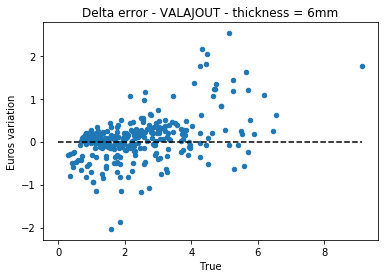

,delta_log
count,299.000000
mean,0.073147
std,0.539117
min,-2.044828
25%,-0.144950
50%,0.084065
75%,0.242950
max,2.536784


In [77]:

thickness = 6

df = comparisonset[comparisonset['thickness']==thickness]

df.plot.scatter('target', 'delta_log')
plt.plot([0, df['target'].max()], [0, 0], color='k', linestyle='--')
plt.title('Delta error - {} - thickness = {}mm'.format(target, thickness))
plt.xlabel('True')
plt.ylabel('Euros variation')
plt.show()
df[['delta_log']].describe()

In [78]:
comparisonset[['COART', 'pred_lgbm_BOXCOX', 'target', 'thickness', 'bend_group']].to_csv(f'../Y3 - Sample data/Z4 - {target}-predictions.csv')

In [79]:
df.shape
#df[['delta_log', 'target', 'pred_lgbm_BOXCOX']]

(299, 677)

In [80]:
#comparison

#Thickness filter
df = comparisonset[comparisonset['thickness'] == 8]

#Cost filter Max
#df = df[df[target]<15]

#Cost filter Min
#df = df[df[target]>10] #bend_count

#Min rectangle area
#df = df[df['minimum_rectangle_area'] < 700000]
df = df[df['minimum_rectangle_area'] > 10000]

#bend_count filter
df = df[df['bend_count'] == 4]

#df[df['COART']=='L3128890'].T
df.T

,218,280,396,567,676,874,1260,1284
COART,L2603300,L3108011,L6014840,L2509970,L2603290,L2520480,L2607650,L3108012
pred_lgbm,3.33799,5.70353,5.34721,4.4875,3.43004,6.1851,7.28101,5.96125
pred_lgbm_BOXCOX,3.2877,4.73359,5.79821,3.85103,3.34389,5.98643,8.0967,4.80613
target,3.85,6.3,5.31,4.5,3.85,6.64,5.78,4.12
MSE_lgbm,0.262154,0.355776,0.00138441,0.000156159,0.176364,0.206937,2.25305,3.39021
MSE_log_lgbm,0.316185,2.45366,0.238352,0.421157,0.256149,0.427152,5.36712,0.470776
cut_length,812.513,1105.28,1797.27,1323.45,812.511,1583.34,3137.92,1148.17
num_closed_patterns,3,7,3,4,3,6,3,8
num_open_patterns,0,0,0,0,0,0,0,0
total_area,16131,26965.1,89761.7,43451.9,16131,84344.4,113772,26845


In [81]:
dataset.loc[['L8835850']].T
#comparisonset[comparisonset['COART'] == 'L3131690']

COART,L8835850
cut_length,6989.19
num_closed_patterns,19
num_open_patterns,0
total_area,196112
minimum_rectangle_area,626653
minimum_rectangle_dim1,1322.67
minimum_rectangle_dim2,473.779
convex_hull_area,530068
no_hole_area,221461
thickness,8


# Official set creation

In [93]:
for target in ['VAMAT', 'VALAJOUT']:
    limitedset = ['cut_length', 'num_closed_patterns', 'num_open_patterns', 'total_area', 'minimum_rectangle_area',
              'minimum_rectangle_dim1', 'minimum_rectangle_dim2', 'convex_hull_area', 'no_hole_area', 'weight']

    # 1 Bend as a float
    limitedset.append('thickness')

    # 3 Different counts
    limitedset.extend(['radius_count', 'direction_count', 'bend_count'])

    # 6 according DXF, sorted by length
    if target != 'VAMAT':
        limitedset.extend([x for x in dataset.columns.values if x.startswith('bendlength_')])
    limitedset.append(target)
    df = dataset[limitedset].reset_index().drop('COART', axis=1)
    df.to_csv(f'../Y3 - Sample data/Z5 - {target}_dataset.csv')